 Develop a CNN-based model capable of accurately identifying melanoma, a potentially fatal form of skin cancer that contributes to 75% of skin cancer-related deaths. Early detection is crucial for improving patient outcomes. By analyzing images and alerting dermatologists to the presence of melanoma, this solution can significantly reduce the manual effort required for diagnosis.

## Importing Skin Cancer Data Set


In [1]:
!wget -O dataset.zip   "https://drive.usercontent.google.com/download?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs&export=download&confirm=t&uuid=72e91b8d-7c31-41ae-9e7a-11e90e3f0bfc"


--2025-02-25 07:30:34--  https://drive.usercontent.google.com/download?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs&export=download&confirm=t&uuid=72e91b8d-7c31-41ae-9e7a-11e90e3f0bfc
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.24.132, 2404:6800:4003:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.24.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 823790659 (786M) [application/octet-stream]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 785.63M   165MB/s    in 6.1s    

2025-02-25 07:30:43 (128 MB/s) - ‘dataset.zip’ saved [823790659/823790659]



In [2]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer ISIC The Internat

In [3]:
!ls

 dataset.zip   sample_data  'Skin cancer ISIC The International Skin Imaging Collaboration'


## Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import ReduceLROnPlateau

In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment utilizes a dataset comprising approximately 2,357 images of various skin cancer types. The dataset is organized into nine subdirectories within both the training and testing folders, with each subdirectory containing images corresponding to a specific type of skin cancer.

### Load using keras.preprocessing

#### Create a dataset
Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
## train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123, validation_split=0.2, subset='training', image_size=(img_height, img_width), batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=155, validation_split=0.2, subset='validation', image_size=(img_height, img_width), batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Lets do some visulisation

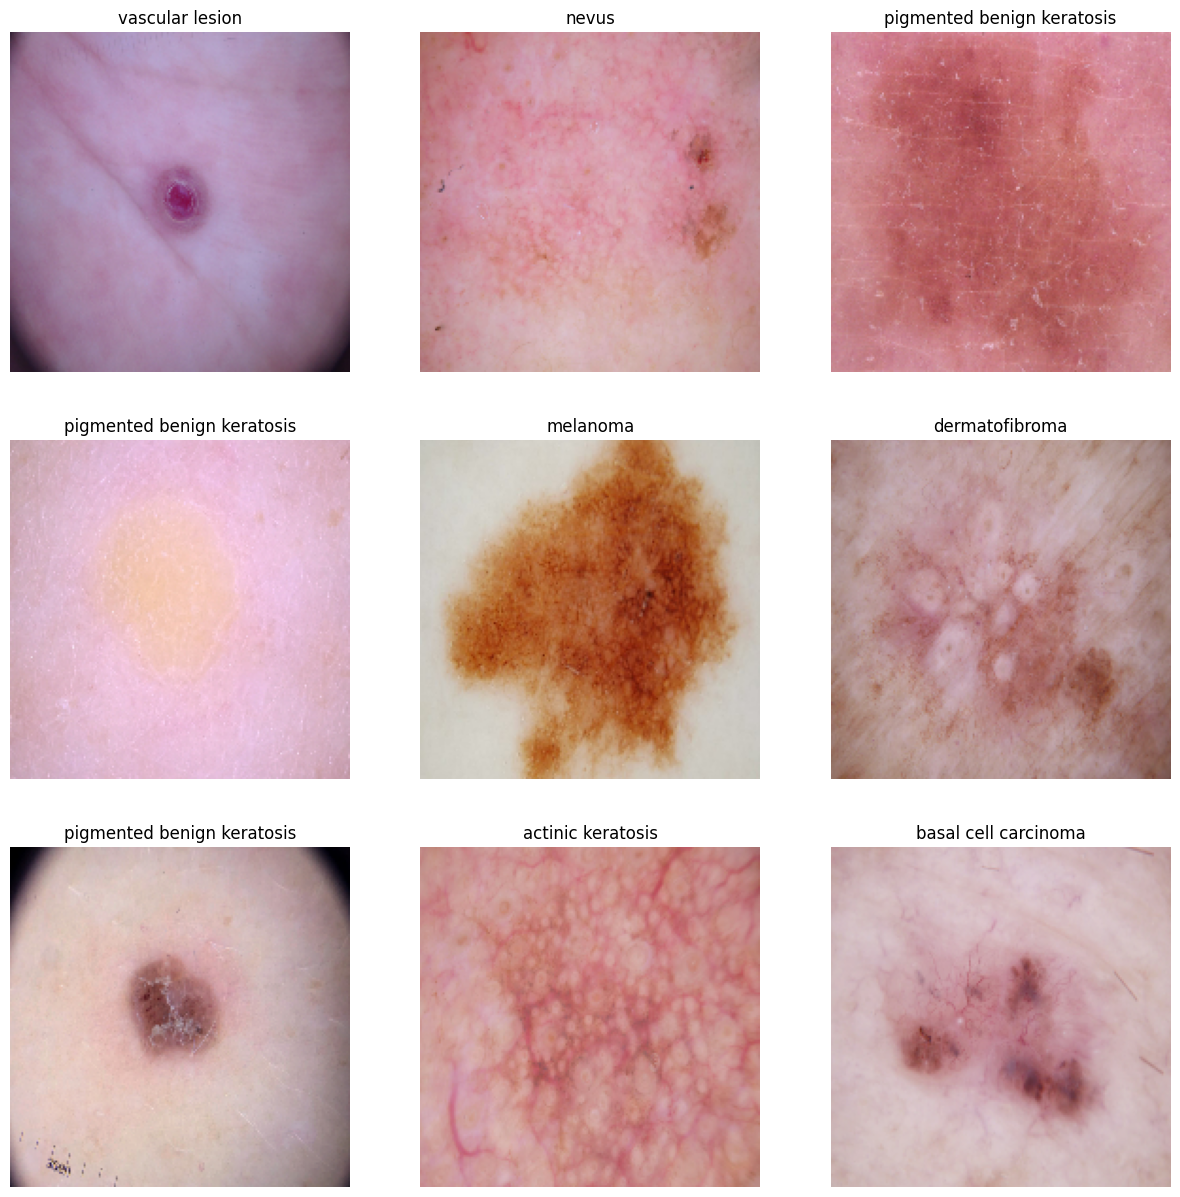

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model
1.  Create a CNN model, which can accurately detect 9 classes present in the dataset. Use `layers.experimental.preprocessing.Rescaling` to normalize pixel values between `(0,1)`. The RGB channel values are in the `(0, 255)` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `(0,1)`

In [13]:
num_classes = 9

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### BASE Models
#### Model 1

In [14]:
# Define the number of classes
num_classes = 9

# Create the CNN model
model = keras.Sequential([
    # Rescaling layer to normalize pixel values between (0,1)
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # Convolutional layers
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output for dense layers
    layers.Flatten(),

    # Dense layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),

    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Model 2

In [15]:
# Define the number of classes
num_classes = 9

model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(layers.Conv2D(32, kernel_size=(3, 3), padding = 'Same', activation= 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, kernel_size=(3, 3), padding = 'Same', activation ='relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, kernel_size=(3, 3), padding = 'Same', activation ='relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, kernel_size=(3, 3), padding = 'Same', activation ='relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(16, kernel_size=(7, 7), padding = 'Same', activation= 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(128, kernel_size=(11,11), padding = 'Same', activation ='relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(256, kernel_size=(3, 3), padding = 'Same', activation ='relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

### Compile the model
#### Choose an appropirate optimiser and loss function for model training

In [16]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=10,
                                  verbose=1,factor=0.2, min_lr=1e-7)

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 22, 22, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 11, 11, 16)          │          50,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 5, 5, 128)           │         247,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 720,601 (2.75 MB)

 Trainable params: 720,601 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 127ms/step - accuracy: 0.1876 - loss: 2.0693 - val_accuracy: 0.2192 - val_loss: 2.1033
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.1908 - loss: 2.0519 - val_accuracy: 0.2192 - val_loss: 2.0374
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.1935 - loss: 2.0213 - val_accuracy: 0.2081 - val_loss: 2.0438
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.2069 - loss: 2.0301 - val_accuracy: 0.2081 - val_loss: 2.0353
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.1946 - loss: 2.0006 - val_accuracy: 0.2081 - val_loss: 2.0293
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.1994 - loss: 2.0249 - val_accuracy: 0.2192 - val_loss: 2.0299
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.2035 - loss: 2.0172 - val_accuracy: 0.2081 - val_loss: 2.0291
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.1944 - loss: 2.0382 - val_accuracy: 0.2192 -

# Visualizing training results

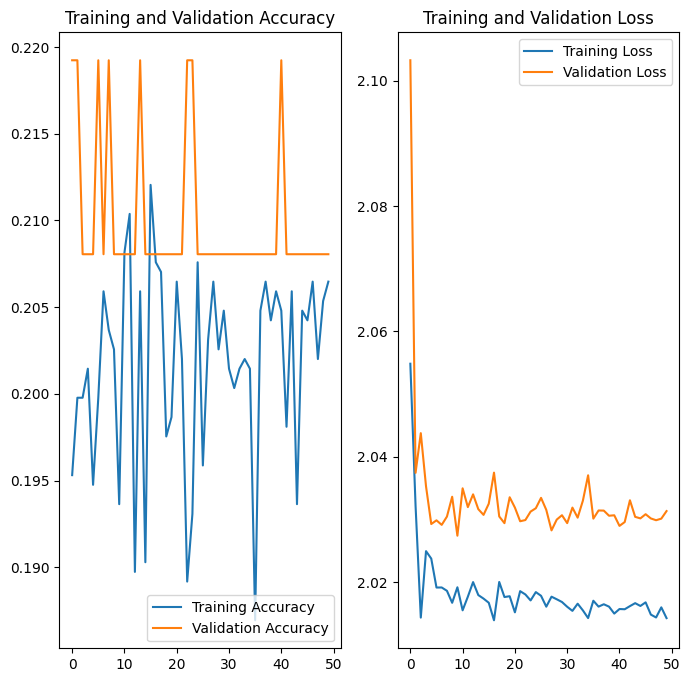

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.RandomCrop(height=160, width=160),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.2)
  ]
)

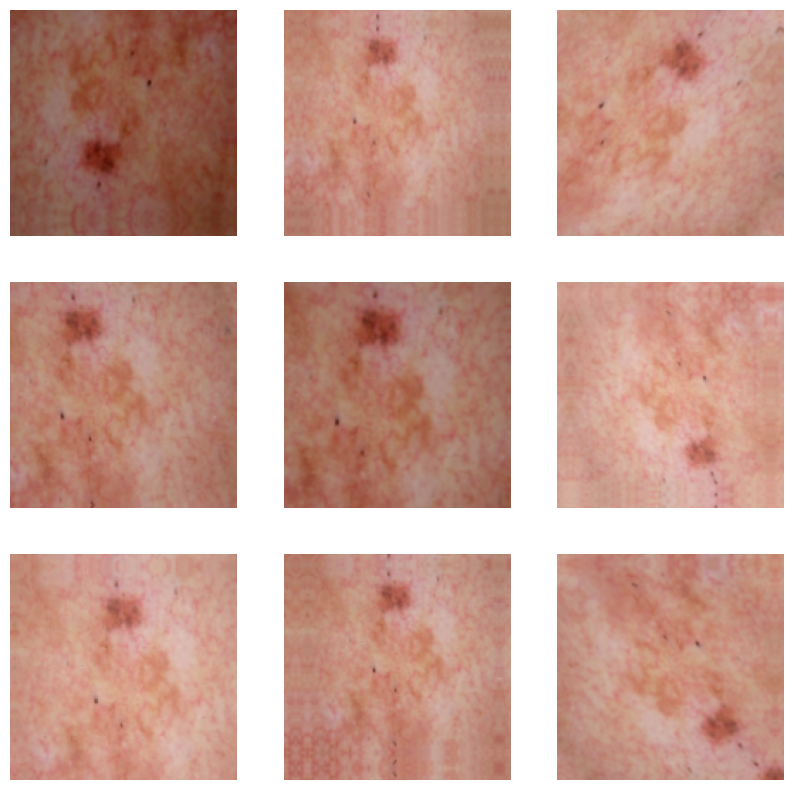

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model

In [24]:
model = keras.Sequential([
    # Input layer
    layers.Input(shape=(180, 180, 3)),

    # Data Augmentation
    data_augmentation,

    # Rescaling layer
    layers.Rescaling(1./255),

    # Convolutional layers
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Global Average Pooling
    layers.GlobalAveragePooling2D(),

    # Dense layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [25]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 160, 160, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 160, 160, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 160, 160, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 160, 160, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 80, 80, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 80, 80, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 80, 80, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 80, 80, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 80, 80, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 80, 80, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 40, 40, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 40, 40, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 40, 40, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 40, 40, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 40, 40, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 40, 40, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,414,217 (5.39 MB)

 Trainable params: 1,412,425 (5.39 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Training the model

In [33]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5)
    ]
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 297ms/step - accuracy: 0.4825 - loss: 1.4016 - val_accuracy: 0.3848 - val_loss: 1.9837 - learning_rate: 0.0010
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 297ms/step - accuracy: 0.5021 - loss: 1.3563 - val_accuracy: 0.5391 - val_loss: 1.2503 - learning_rate: 0.0010
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - accuracy: 0.4535 - loss: 1.4494 - val_accuracy: 0.5257 - val_loss: 1.4350 - learning_rate: 0.0010
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 300ms/step - accuracy: 0.4721 - loss: 1.4230 - val_accuracy: 0.4899 - val_loss: 1.4292 - learning_rate: 0.0010
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 300ms/step - accuracy: 0.4815 - loss: 1.3967 - val_accuracy: 0.5459 - val_loss: 1.3260 - learning_rate: 0.0010
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 305ms/step - accuracy: 0.4896 - loss: 1.3874 - val_accuracy: 0.5011 - val_loss: 1.3785 - learning_rate: 0.0010
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.4715 - loss: 1.4

TypeError: This optimizer was created with a `LearningRateSchedule` object as its `learning_rate` constructor argument, hence its learning rate is not settable. If you need the learning rate to be settable, you should instantiate the optimizer with a float `learning_rate` argument.

In [34]:
epochs = 90

### Visualizing the results

ValueError: x and y must have same first dimension, but have shapes (90,) and (50,)

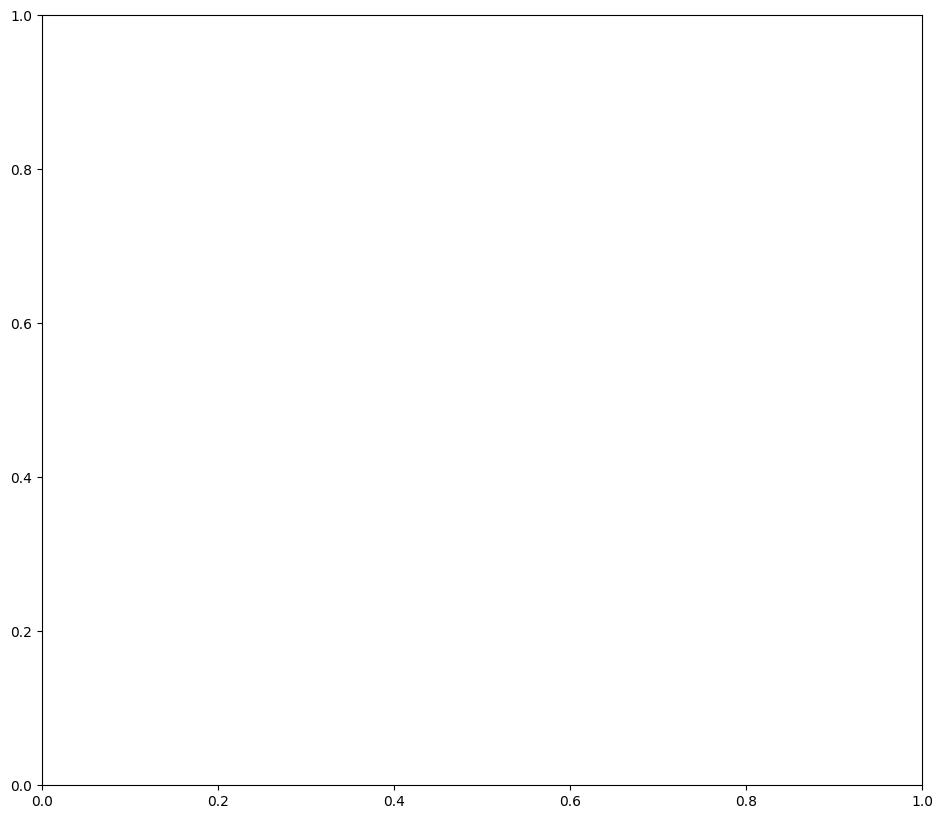

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [38]:
# images in each classes
class_diff=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)

class_diff

AttributeError: 'DataFrame' object has no attribute 'append'

In [37]:
class_diff.number.sum()

AttributeError: 'DataFrame' object has no attribute 'number'

In [ ]:
# Print class distribution
total_samples = class_diff.number.sum()
print("Class Distribution:")
for index, row in class_diff.iterrows():
    class_name = row['class']
    count = row['number']
    percentage = (count / total_samples) * 100
    print(f"{class_name}: {count} samples ({percentage:.2f}%)")

# Visualize the distribution
plt.figure(figsize=(12, 6))
plt.bar(class_diff['class'], class_diff['number'])
plt.title('Distribution of Classes in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print some summary statistics
print(f"\nTotal samples: {total_samples}")
print(f"Number of classes: {len(class_diff)}")
print(f"Largest class: {class_diff['class'][class_diff['number'].idxmax()]} with {class_diff['number'].max()} samples")
print(f"Smallest class: {class_diff['class'][class_diff['number'].idxmin()]} with {class_diff['number'].min()} samples")
print(f"Imbalance ratio: {class_diff['number'].max() / class_diff['number'].min():.2f}")

Context: We can use a python package known as [Augmentor](https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

In [29]:
!ls "Skin cancer ISIC The International Skin Imaging Collaboration"

Test  Train


In [ ]:
import os
import Augmentor

# Use raw string for the base path
base_path = r"Skin cancer ISIC The International Skin Imaging Collaboration/Train"

for i in class_names:
    # Use os.path.join to create the full path
    class_path = os.path.join(base_path, i)
    print(f"Processing: {class_path}")

    # Create the Augmentor pipeline
    p = Augmentor.Pipeline(class_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # We are adding 500 samples per class to make sure that none of the classes are sparse.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

In [ ]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

image_dict = dict(zip(images_path_list, lesions_list))
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
# lesions_df.head()

## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = lesions_df.append(df2)
new_df.shape

In [ ]:
new_df['Label'].value_counts()

In [ ]:
round(new_df['Label'].value_counts(normalize=True)*100, 2)

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
data_dir_train=pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))


In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Test the model

In [ ]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-4],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get class names
class_names = test_ds.class_names

# Optimize the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)


print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

In [ ]:
y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
    pred_probs = model.predict(image_batch)
    y_pred.extend(np.argmax(pred_probs, axis=1))
    y_true.extend(label_batch.numpy())

# Convert to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate and print classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

# Generate and plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Model Accuracy in respect of melanoma class

In [ ]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

melanoma_index = class_names.index('melanoma')

# binary classification problem: melanoma vs. not melanoma
y_true_binary = (y_true == melanoma_index).astype(int)
y_pred_binary = (y_pred == melanoma_index).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_true_binary, y_pred_binary)

# True Positives, False Positives, True Negatives, False Negatives
TP = cm[1][1]
FP = cm[0][1]
TN = cm[0][0]
FN = cm[1][0]

# Calculate metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = precision_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
f1 = f1_score(y_true_binary, y_pred_binary)

print(f"Melanoma Class Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Print the confusion matrix
print("\nConfusion Matrix:")
print(f"TN: {TN}, FP: {FP}")
print(f"FN: {FN}, TP: {TP}")

# Calculate and print specificity
specificity = TN / (TN + FP)
print(f"\nSpecificity: {specificity:.4f}")

In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()